In [1]:
using PyPlot
using UMAP
using LinearAlgebra
using Distributions
using Random
using Flux
using Zygote
using SpecialFunctions
using LogLinearModels
using StatsBase
using BoltzmannMachines
using Statistics

In [2]:
include("patternextractor.jl")

makeconstraint (generic function with 2 methods)

# Code for training VAEs

In [3]:
# Principal component analysis (PCA)

function standardize2(x)
    (x .- mean(x, dims = 1)) ./ std(x, dims = 1)
end

function prcomps(mat, standardizeinput = true)
    if standardizeinput
        mat = standardize2(mat)
    end
    u,s,v = svd(mat)
    prcomps = u * Diagonal(s)
    return prcomps
end


struct VAE
	encoder
	mu
	logsigma
	decoder
end

# struct XYZ
#    encoder

function bernoulliloss(xhat,x)
	ce(x,y) =  y * log(x + eps()) + (1 - y) * log(1 - x + eps())
	# logpdf(b::Bernoulli,y::Bool) = y * log(b.p + eps()) + (1-y) * log(1-b.p + eps())
	# return sum(Distributions.logpdf.(Bernoulli.(xhat),x))
	return sum(ce.(xhat,x))
end

    
function normalz(mu,logsigma)
	return mu  + exp(logsigma) * randn()
end



function kullbackleiblerqp(mu,logsigma)
	return 0.5 * sum(exp.(2 .* logsigma) + mu.^2 .- 1 .- 2 .* logsigma)
end


g(x) = (h = vae.encoder(x); (vae.mu(h), vae.logsigma(h)))	

loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)

loss (generic function with 1 method)

In [4]:
function posteriorsample(x) 
    mu,logsigma = g(x)
    zs = normalz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

function priorsample(x) 
    mu,logsigma = g(x)
    mu = zeros(length(mu))
    logsigma = zeros(length(logsigma))
    zs = normalz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

priorsample (generic function with 1 method)

# Code for simulated data

## Simulated data for using log-linear and linear models to shape the latent space with a binary endpoint 

In [5]:
n = 250
a = 2
b = -2

-2

In [6]:
g1c1z1 = rand(Normal(a,1),n)
g1c2z1 = rand(Normal(b,1),n)
g1c1z2 = rand(Normal(a,1),n)
g1c2z2 = rand(Normal(a,1),n)

g2c1z2 = rand(Normal(a,1),n)
g2c2z2 = rand(Normal(b,1),n)
g2c1z1 = rand(Normal(a,1),n)
g2c2z1 = rand(Normal(a,1),n)


250-element Vector{Float64}:
  2.5202478436990505
  1.5750819590406864
  2.2976427433453797
  2.6363441237011918
  3.5805027031152354
  0.3114926590976248
  1.7593830381818463
  3.823911334087029
  1.491498675689383
  2.3280609698313937
  2.4074224328621803
  1.349421674859846
 -0.6388291615070281
  ⋮
  3.3788757668148297
  2.3364264645172357
  2.0698887724799664
  2.4796623520705903
  1.602267685695218
  0.9918526086061055
  3.5087350437950295
  2.044042081460528
  2.272820850698121
  1.304154079872485
  2.2992735831044095
  3.127699281836385

In [7]:
z1 = cat([g1c1z1,g1c2z1,g2c1z1,g2c2z1]...,dims=1)
z2 = cat([g1c1z2,g1c2z2,g2c1z2,g2c2z2]...,dims=1)

1000-element Vector{Float64}:
  2.4639340570943706
  1.1884784107669957
  1.310028154858491
  3.244453286806815
  2.3803437567758916
  1.6762521738918306
  1.0257211479027664
  2.57400252842019
  2.0857856960276155
  0.46913331589293716
  2.189322891717639
  1.1342473669204018
  0.9290086090727718
  ⋮
 -1.6419889609730696
 -1.294524848903869
 -2.3783174600359005
 -0.9794586156366354
 -1.7025635420204375
 -2.745499519702969
  0.18860834591400355
 -2.585965026113153
 -0.5005455830005499
 -1.47118617253127
 -1.994819943708241
 -3.5448559040460172

In [8]:
cellfactor = cat([fill(1,n),fill(2,n),fill(1,n),fill(3,n)]...,dims=1)
groupfactor = cat([fill(1,n*2),fill(2,n*2)]...,dims=1)

1000-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2

In [9]:
col = ["r","deepskyblue"]
gcols = col[groupfactor]
col = ["r", "deepskyblue", "lime"]
ccols = col[cellfactor]

1000-element Vector{String}:
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 ⋮
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"

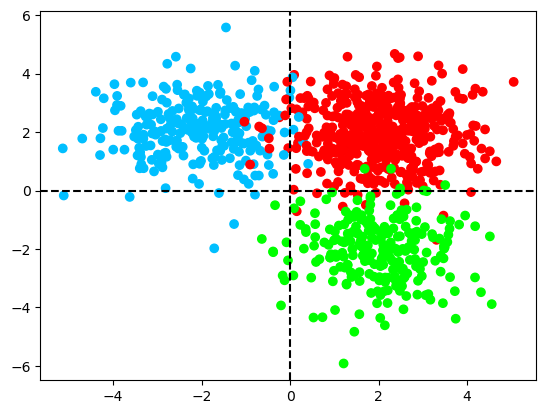

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/moritz/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject <matplotlib.lines.Line2D object at 0x20f157bb0>

In [10]:
PyPlot.scatter(z1,z2,c=ccols)
PyPlot.axhline(y = 0.0,c="black",linestyle="--")
PyPlot.axvline(x = 0.0,c="black",linestyle="--")

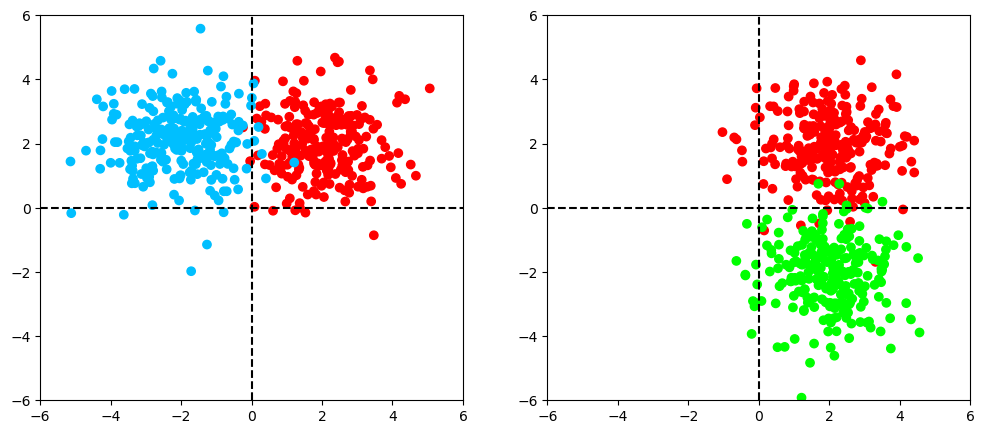

PyObject <matplotlib.lines.Line2D object at 0x20f3a3f70>

In [11]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
g1i = groupfactor .== 1
ax[1].scatter(z1[g1i],z2[g1i],c=ccols[g1i])
ax[1][:set_ylim]([-6,6])
ax[1][:set_xlim]([-6,6])
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
g2i = groupfactor .== 2
ax[2].scatter(z1[g2i],z2[g2i],c=ccols[g2i])
ax[2][:set_ylim]([-6,6])
ax[2][:set_xlim]([-6,6])
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

In [12]:
x = zeros(n*4,10)

1000×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.

In [13]:
for i=1:5
    x[:,i] = z1 + rand(Normal(0,1),n*4)
end

In [14]:
for i=6:10
    x[:,i] = z2 + rand(Normal(0,1),n*4)
end

In [15]:
x01 = convert(Array{Float64,2},ifelse.(x.>0,1,0))

1000×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
 1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0
 ⋮                        ⋮                   
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  1.0  0.

In [16]:
noisevars = convert(Array{Float64,2},rand(1000,20) .> 0.5)

1000×20 Matrix{Float64}:
 0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  …  0.0  1.0  1.0  0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  1.0  1.0  1.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0     0.0  1.0  1.0  0.0  0.0  1.0  0.0
 1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  1.0  1.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0     1.0  0.0  1.0  0.0  0.0  0.0  1.0
 0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0     0.0  1.0  0.0  0.0  1.0  1.0  0.0
 0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0     1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  1.0  0.0  1.0
 0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  …  0.0  1.0  0.0  0.0  1.0  1.0  1.0
 1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0     1.0  1.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0

In [17]:
x01 = hcat([x01,noisevars]...)

1000×30 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  1.0  1.0  0.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  0.0  0.0  1.0
 1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0     0.0  1.0  1.0  0.0  0.0  1.0  0.0
 1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  1.0  1.0  1.0  0.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  0.0  1.0  0.0  0.0  0.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  1.0  0.0  0.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  0.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  1.0  0.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  …  0.0  1.0  0.0  0.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0     1.0  1.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

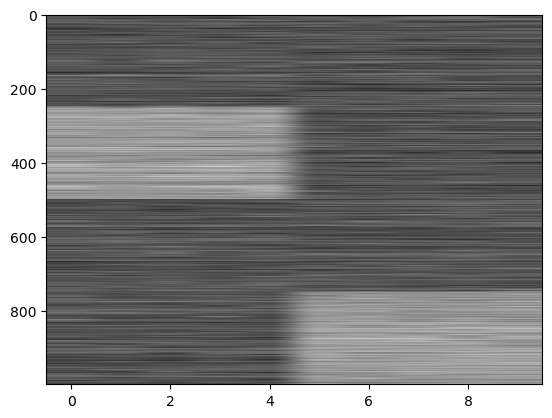

PyObject <matplotlib.image.AxesImage object at 0x20f430070>

In [18]:
PyPlot.imshow(x,aspect="auto",cmap="binary")

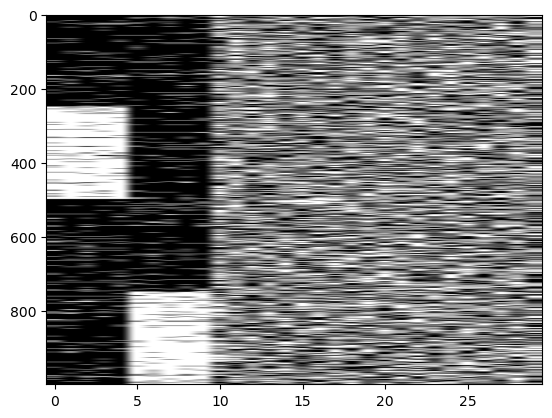

PyObject <matplotlib.image.AxesImage object at 0x20f479eb0>

In [19]:
PyPlot.imshow(x01,aspect="auto",cmap="binary")

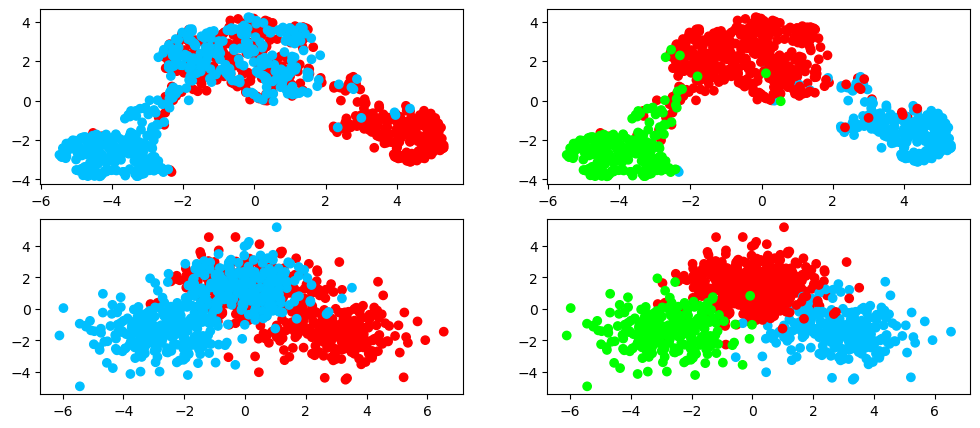

PyObject <matplotlib.collections.PathCollection object at 0x2176c92b0>

In [20]:
umap_mat = umap(Transpose(x))
pcs = prcomps(standardize2(x))[:,1:2];
fig, ax = PyPlot.subplots(nrows=2, ncols=2, figsize=(12, 5))
ax[1,1].scatter(umap_mat[1,:],umap_mat[2,:],c=gcols)
ax[1,2].scatter(umap_mat[1,:],umap_mat[2,:],c=ccols)
ax[2,1].scatter(pcs[:,1],pcs[:,2],c=gcols)
ax[2,2].scatter(pcs[:,1],pcs[:,2],c=ccols)

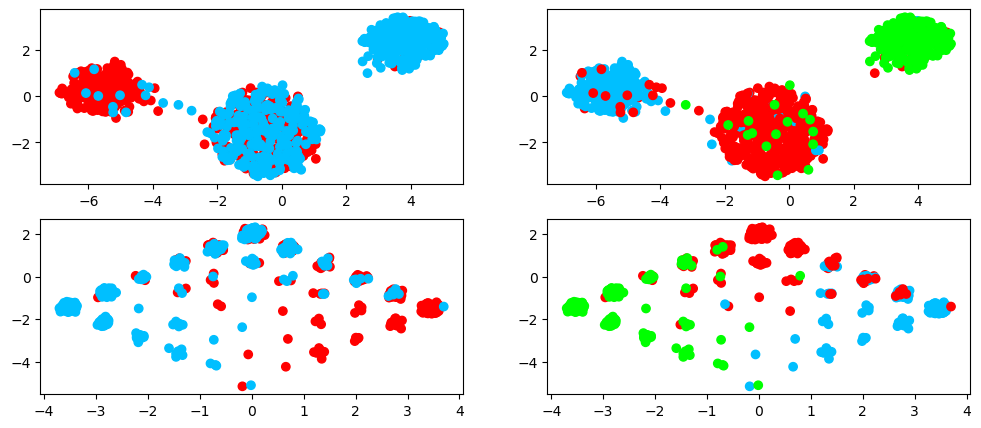

PyObject <matplotlib.collections.PathCollection object at 0x21782b8e0>

In [21]:
umap_mat = umap(Transpose(x01))
pcs = prcomps(x01)[:,1:2];
fig, ax = PyPlot.subplots(nrows=2, ncols=2, figsize=(12, 5))
ax[1,1].scatter(umap_mat[1,:],umap_mat[2,:],c=gcols)
ax[1,2].scatter(umap_mat[1,:],umap_mat[2,:],c=ccols)
ax[2,1].scatter(pcs[:,1],pcs[:,2],c=gcols)
ax[2,2].scatter(pcs[:,1],pcs[:,2],c=ccols)

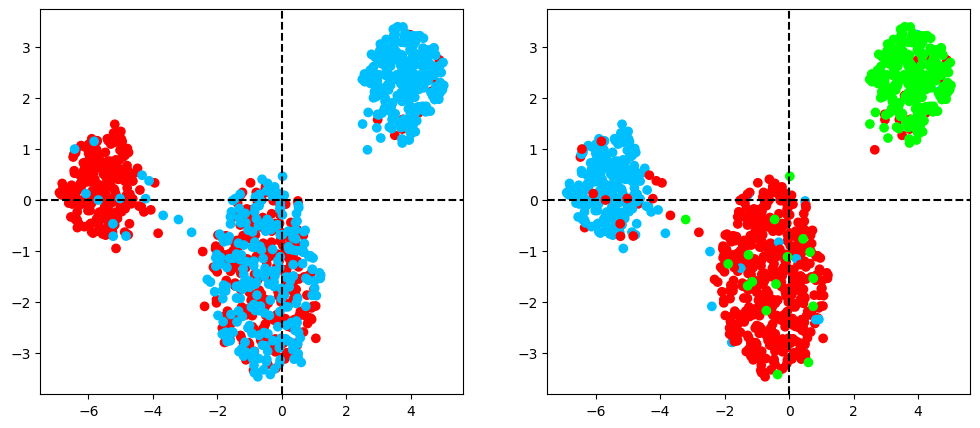

PyObject <matplotlib.lines.Line2D object at 0x217961910>

In [22]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[1].scatter(umap_mat[1,:],umap_mat[2,:],c=gcols)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(umap_mat[1,:],umap_mat[2,:],c=ccols)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

In [23]:
n,p = size(x01)

(1000, 30)

In [24]:
randindex = Random.randperm(n);
trainidx = randindex[1:Int(round(.632*n))];
testidx = randindex[Int(round(.632*n))+1:n];
testdata = [x01[i,:]' for i in Iterators.partition(testidx,1)]; 
evalvae() = (push!(losslist,sum(lossplus.(testdata[1:10],testys[1:10]))))#;println(sum(x->sum(x.^2),Flux.params(vae.decoder))))

evalvae (generic function with 1 method)

In [25]:
testdata

368-element Vector{Adjoint{Float64, Matrix{Float64}}}:
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [0.0; 1.0; … ; 0.0; 1.0;;]
 [0.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [0.0; 0.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 ⋮
 [0.0; 0.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [0.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [0.0; 0.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [0.0; 0.0; … ; 0.0; 1.0;;]

In [26]:
col = ["lightgrey","k"]
gcols = col[groupfactor[testidx]]
col = ["r", "deepskyblue", "lime"]
ccols = col[cellfactor[testidx]]

368-element Vector{String}:
 "r"
 "r"
 "r"
 "r"
 "lime"
 "r"
 "r"
 "lime"
 "lime"
 "r"
 "r"
 "deepskyblue"
 "lime"
 ⋮
 "deepskyblue"
 "r"
 "lime"
 "lime"
 "r"
 "r"
 "lime"
 "lime"
 "r"
 "deepskyblue"
 "r"
 "deepskyblue"

# Train VAE

In [27]:
Random.seed!(1234)
Dh = 30
Dz = 2
epochs = 50
learningrate = 0.004
batchsize=10
Beta =1

1

In [28]:
loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)

loss (generic function with 1 method)

In [29]:
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh)),
    Flux.Dense(Dh,Dz),
    Flux.Dense(Dh,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

VAE(Chain(Dense(30, 30, tanh)), Dense(30, 2), Dense(30, 2), Chain(Dense(2, 30, relu), Dense(30, 30, σ)))

In [30]:
optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)

Params([Float32[-0.21166883 -0.036679838 … -0.09168885 0.094487116; 0.050509237 0.23434964 … 0.27464327 -0.031743303; … ; -0.02800931 -0.13444553 … 0.2145687 0.22609095; 0.1939767 0.22877489 … -0.16312665 0.2823618], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.23465197 0.22051999 … 0.07838469 -0.034903724; 0.21626312 0.045496177 … -0.36964485 0.0015206997], Float32[0.0, 0.0], Float32[-0.42893928 0.370592 … 0.11676181 -0.32878834; 0.25255343 -0.03477674 … 0.225178 0.16739601], Float32[0.0, 0.0], Float32[0.1933963 0.06880604; 0.36454853 0.33934513; … ; 0.34757817 0.2702324; 0.3253124 0.11031515], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.14380309 -0.3017917 … 0.063717805 -0.0048677; 0.09285279 -0.01082798 … -0.13923407 0.11875712; … ; -0.31188414 0.052131128 … -0.29600835 0.16998582; 0.1445122 0.17016178 … -0.30094182 0.26255414], 

Write a custom training loop

In [31]:
losslist = []
for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            #println(ys)
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end


# Check output from VAE

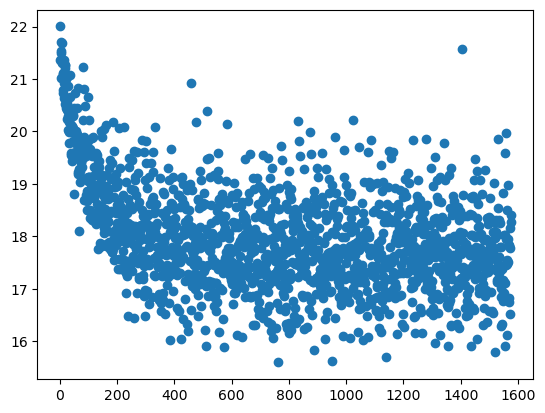

PyObject <matplotlib.collections.PathCollection object at 0x2179c13a0>

In [32]:
PyPlot.scatter(collect(1:length(losslist)),losslist)

In [33]:
zs = Transpose(cat(dims=2,map(x-> x[1],g.(testdata))...))

368×2 transpose(::Matrix{Float64}) with eltype Float64:
 -0.17957     0.679873
 -0.151593    0.820326
 -0.509021    0.786595
 -0.016952    0.815743
  0.0298041  -1.10345
 -0.275563    0.464783
 -0.156108    0.394851
 -0.739993   -0.754459
 -0.755161   -1.23819
 -0.358261    0.871161
 -0.559725    0.750792
  1.38785     0.0986914
 -0.749837   -1.10997
  ⋮          
  1.38203    -1.42199
 -0.467088    0.912818
 -0.227878   -1.15319
 -0.730337   -1.41097
 -0.337538    0.165206
 -0.341237    0.962139
 -0.623186   -0.999868
 -0.728682   -1.24698
 -0.457562    0.957305
  1.5432      0.110488
 -0.210941   -0.00330367
  1.48879    -0.720461

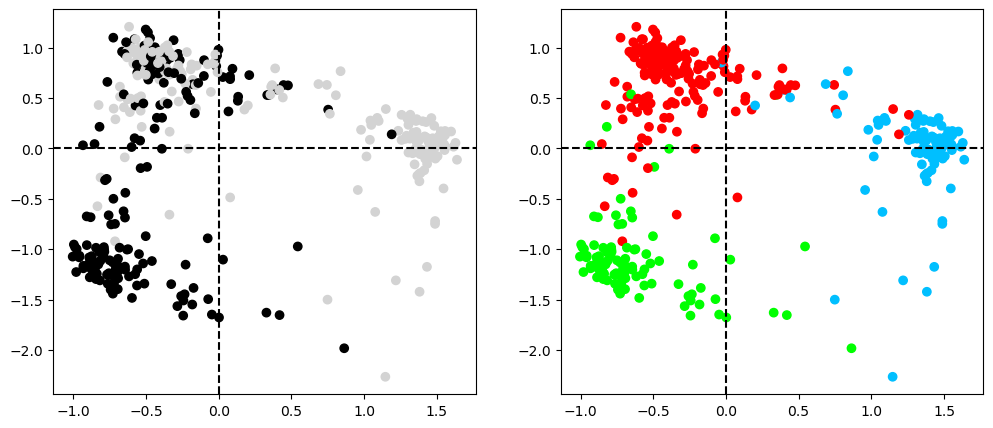

PyObject <matplotlib.lines.Line2D object at 0x218066880>

In [34]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[1].scatter(zs[:,1],zs[:,2],c=gcols)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(zs[:,1],zs[:,2],c=ccols)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

In [35]:
zs = Transpose(cat(dims=2,map(x-> x[1],posteriorsample.(testdata))...))

368×2 transpose(::Matrix{Float64}) with eltype Float64:
  0.26358    1.22212
 -0.880611   0.610273
  0.357988   0.253256
  0.906208   0.577598
  0.22883   -1.76703
 -0.204737   0.577187
  0.249896  -0.234475
 -1.25514   -0.741843
 -0.484386  -0.81208
 -0.382796   1.29994
 -0.148875   0.622507
  1.37419    0.177432
 -1.71591   -0.858951
  ⋮         
  2.23322   -0.376358
 -0.805403   0.313898
  0.150208  -0.723684
 -0.786639  -1.91198
 -0.54535   -0.288831
  0.116016   1.63957
 -1.00651   -1.42004
 -0.873881  -1.63297
 -0.441413   0.267824
  2.19603   -0.123848
 -0.755022  -0.487056
  1.82301   -1.05293

## Left labelled according to group, right labelled according to celltype

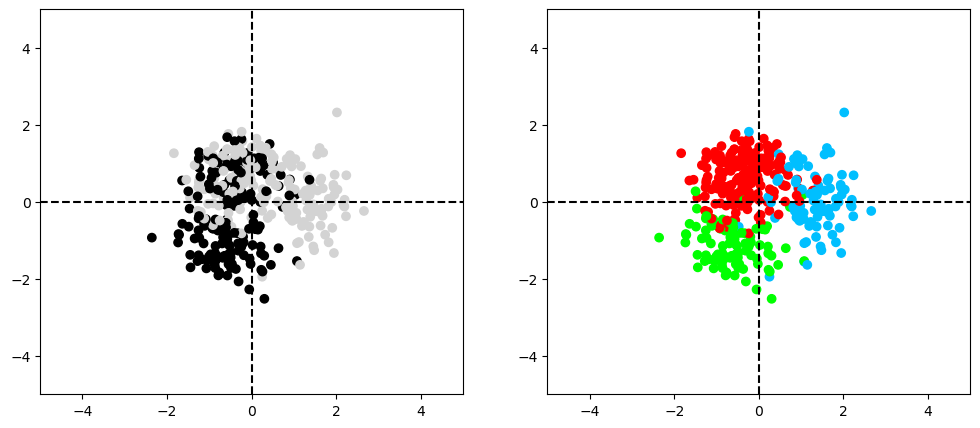

PyObject <matplotlib.lines.Line2D object at 0x218141490>

In [36]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 5
ax[1].scatter(zs[:,1],zs[:,2],c=gcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(zs[:,1],zs[:,2],c=ccols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

# Draw samples from trained VAE

In [37]:
vaesamples = priorsample.(vcat([testdata for i = 1:10]...))

3680-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.8269663245760153, -0.6543917092606906], [0.2581328056075121, 0.21622984177365595, 0.2115352478944192, 0.28745908417043525, 0.216732538379223, 0.7782094925430325, 0.8352284200887573, 0.8262927732899534, 0.8197385225528243, 0.8009488740773494  …  0.48353504740932807, 0.5582858470565814, 0.4417230067377791, 0.5346367530583971, 0.5085412317821526, 0.5383172087998325, 0.5497590080145291, 0.5248827010556713, 0.47893062200825987, 0.47528524965626184])
 ([0.2961307245636859, -1.1629161916276305], [0.6745375164880347, 0.6735248495287756, 0.6026086268069702, 0.6771567790317773, 0.6006515236919698, 0.195250797533488, 0.3265394895769189, 0.24538793640030546, 0.27365830875661046, 0.2643486518840636  …  0.5157176257695945, 0.5651159744776402, 0.43809678763153426, 0.48668149355771345, 0.5093973023775511, 0.5139888547345193, 0.5443082542008144, 0.5109319289290323, 0.5069268839905626, 0.47238522359765905])
 ([0.4724494433146802, -1.7801

In [38]:
vaepostsamples = posteriorsample.(vcat([testdata for i = 1:10]...))

3680-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([0.2570264222474481; 1.175558934726146;;], [0.8932020822276325; 0.8993766666312407; … ; 0.481200852450333; 0.47013337483665113;;])
 ([0.8025675469342548; 0.9944827151113176;;], [0.5582366687770604; 0.5152375368784237; … ; 0.4846331694378352; 0.44524146905090245;;])
 ([-1.2055055150681828; 0.2892836680815122;;], [0.9914902630664025; 0.9953632231559063; … ; 0.4212864248560976; 0.48066686421068;;])
 ([-0.5488855380223767; 1.3644248043748335;;], [0.9848061750289594; 0.9901443029781274; … ; 0.43879094169447236; 0.47707959252738696;;])
 ([-0.6521436976632599; -1.431580604580061;;], [0.9447526262860985; 0.9591251310828899; … ; 0.486385775475965; 0.42001277944811;;])
 ([-0.4276188014126674; 0.979338944379508;;], [0.9748022529807038; 0.9822309764102907; … ; 0.4578209851478005; 0.4819603943214436;;])
 ([-0.5799800864521085; 0.48980773785406817;;], [0.9735788418004548; 0.9816573984528907; … ; 0.45841445857972074; 0.48647987420006195;

In [39]:
vaesamples = vaepostsamples

3680-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([0.2570264222474481; 1.175558934726146;;], [0.8932020822276325; 0.8993766666312407; … ; 0.481200852450333; 0.47013337483665113;;])
 ([0.8025675469342548; 0.9944827151113176;;], [0.5582366687770604; 0.5152375368784237; … ; 0.4846331694378352; 0.44524146905090245;;])
 ([-1.2055055150681828; 0.2892836680815122;;], [0.9914902630664025; 0.9953632231559063; … ; 0.4212864248560976; 0.48066686421068;;])
 ([-0.5488855380223767; 1.3644248043748335;;], [0.9848061750289594; 0.9901443029781274; … ; 0.43879094169447236; 0.47707959252738696;;])
 ([-0.6521436976632599; -1.431580604580061;;], [0.9447526262860985; 0.9591251310828899; … ; 0.486385775475965; 0.42001277944811;;])
 ([-0.4276188014126674; 0.979338944379508;;], [0.9748022529807038; 0.9822309764102907; … ; 0.4578209851478005; 0.4819603943214436;;])
 ([-0.5799800864521085; 0.48980773785406817;;], [0.9735788418004548; 0.9816573984528907; … ; 0.45841445857972074; 0.48647987420006195;

In [40]:
zs = Transpose(cat(dims=2,map(x-> x[1],vaesamples)...))
xs = Transpose(cat(dims=2,map(x-> x[2],vaesamples)...))

3680×30 transpose(::Matrix{Float64}) with eltype Float64:
 0.893202   0.899377   0.887521   0.915968   …  0.559473  0.481201  0.470133
 0.558237   0.515238   0.534048   0.606113      0.553166  0.484633  0.445241
 0.99149    0.995363   0.992083   0.993993      0.561934  0.421286  0.480667
 0.984806   0.990144   0.985533   0.990082      0.563701  0.438791  0.47708
 0.944753   0.959125   0.925918   0.940242      0.537051  0.486386  0.420013
 0.974802   0.982231   0.974435   0.982241   …  0.55385   0.457821  0.48196
 0.973579   0.981657   0.973115   0.980481      0.550352  0.458414  0.48648
 0.840977   0.860021   0.79457    0.833358      0.510928  0.512182  0.462109
 0.97866    0.986829   0.971103   0.976611      0.544511  0.456342  0.401886
 0.961153   0.971198   0.958982   0.96968       0.548413  0.470647  0.482508
 0.991861   0.995627   0.992989   0.994895   …  0.571314  0.419466  0.483085
 0.192009   0.146813   0.164827   0.214042      0.527842  0.472463  0.456423
 0.970942   0.981066 

# Dichotomize samples 
You could also use the dichotomize function to cut the samples at a given quantile if you trained the VAE with count data.

In [41]:
zsbin = ifelse.(zs.>0,1,0)
xsbin = float.(xs .> rand(size(xs)...))

3680×30 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  0.0  1.0  0.0
 0.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  0.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0     1.0  0.0  1.0  0.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  0.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0     1.0  1.0  0.0  1.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  1.0  1.0
 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0     1.0  0.0  1.0  1.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0

In [49]:
nvars = 12

12

In [42]:
res = select_k_variables(nvars,[converttoleveldata([xsbin,zsbin])],evolution=true)

([1720.295745539217, 1715.788175481705, 507.70757696692067, 391.9611741271208, 248.67793375615733, 242.94262003161637, 178.22000298257308, 178.6918089777936, 150.59289139885513, 158.94214233529024, 96.1772522035024, 105.63789208703233], [2, 6, 8, 3, 5, 7, 1, 10, 4, 9, 18, 19], Any[[1489.5181652153458 31.56059742285592; 1720.295745539217 21.577201416326005; … ; 0.06375285200829595 3.6751250387843086; 1.6512978712988442 0.12013542278451261], [405.4828310674932 13.7264794412479; 0.0 0.0; … ; 5.00872968984579 3.9530695217078033; 0.5862656901060941 2.349433964899603], [389.3409207207653 53.59493608504036; 0.0 0.0; … ; 5.5645235198037 5.428840423401244; 1.4408263430478847 3.7627999947540545], [381.8171867612079 69.09142000381041; 0.0 0.0; … ; 6.8008613862282985 6.917922404110554; 4.951223343262335 5.73895366516944], [230.4101300863752 39.159091545352936; 0.0 0.0; … ; 5.989906083810622 14.270533829783384; 14.517799089479562 7.754609553428315], [168.06775876124448 39.349493031652806; 0.0 0.0; 

## Inspect the G-Squared matrix for each selected variable
The Matrix indicates the G-Squared statistic used for selecting a variable at a given iteration (here 12 iterations evaluated).
In the below stated example, g-squared matrix for iteration 6 (based on which the 6th variable is selected) is shown.

In [54]:
grid = PyPlot.ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

LoadError: UndefVarError: ImageGrid not defined

In [ ]:
for i =  1:nvars
    ax[i] = PyPlot.imshow(res[3][i],aspect="auto",cmap="binary")
end

In [64]:
res[1]

12-element Vector{Float64}:
 1720.295745539217
 1715.788175481705
  507.70757696692067
  391.9611741271208
  248.67793375615733
  242.94262003161637
  178.22000298257308
  178.6918089777936
  150.59289139885513
  158.94214233529024
   96.1772522035024
  105.63789208703233

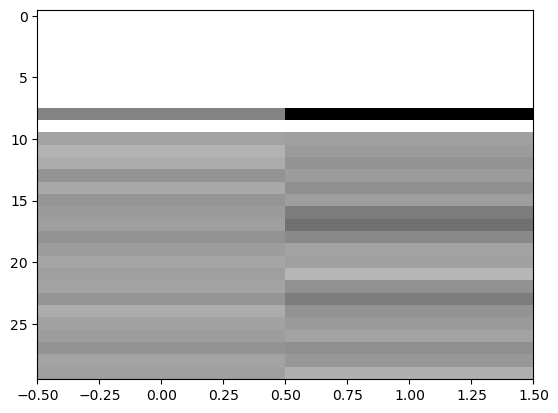

PyObject <matplotlib.image.AxesImage object at 0x21b3edb80>

In [63]:
ax = PyPlot.imshow(res[3][10],aspect="auto",cmap="binary")

## Here we infer the labels for the synthetic observations drawn from a VAE based on testdata.

In [44]:
yhat = annotatesamplesbypattern(Transpose(hcat(testdata...)),xsbin[1:500,:],res[2],ccols)

500-element Vector{String}:
 "r"
 "lime"
 "r"
 "r"
 "r"
 "r"
 "r"
 "lime"
 "lime"
 "r"
 "r"
 "deepskyblue"
 "lime"
 ⋮
 "deepskyblue"
 "lime"
 "r"
 "deepskyblue"
 "r"
 "lime"
 "r"
 "lime"
 "r"
 "lime"
 "r"
 "lime"

## Here we inspect how synthetic observations were labeled

In [45]:
pzs = zs[1:500,:]

500×2 Matrix{Float64}:
  0.257026    1.17556
  0.802568    0.994483
 -1.20551     0.289284
 -0.548886    1.36442
 -0.652144   -1.43158
 -0.427619    0.979339
 -0.57998     0.489808
 -0.0797753  -1.47613
 -1.22208    -1.62304
 -0.470873    0.207662
 -1.00575     1.03974
  1.04777     0.168016
 -0.909066   -1.01597
  ⋮          
 -0.751933    0.177696
 -0.724445   -1.37504
 -0.672308    0.727482
  2.0356     -0.278556
 -0.534173   -0.241611
  1.82662    -1.1485
 -0.446721    1.85375
 -1.89271    -1.22352
 -0.42839     0.851715
 -1.64358    -1.55589
  0.082094    0.774718
 -0.482801   -1.25657

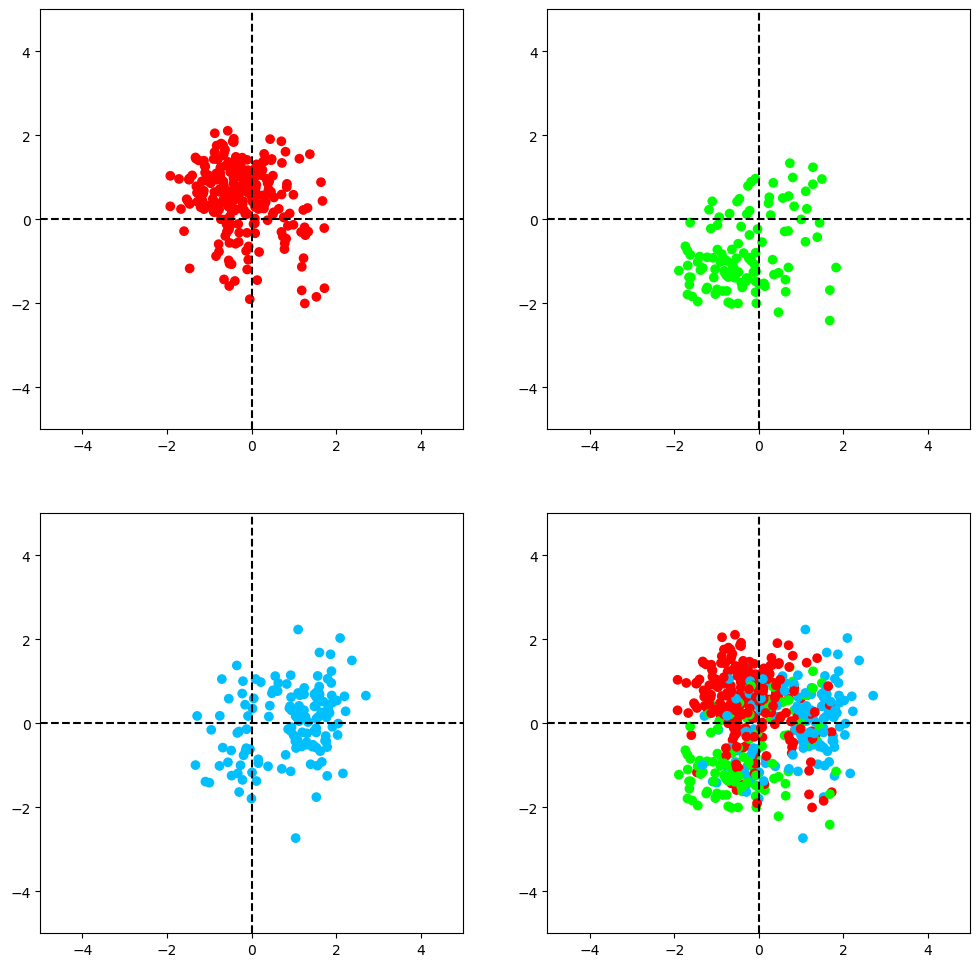

PyObject <matplotlib.lines.Line2D object at 0x21a7e0f70>

In [46]:
fig, ax = PyPlot.subplots(nrows=2, ncols=2, figsize=(12, 12))
scalepar = 5
ax[1].scatter(pzs[yhat.=="r",1],pzs[yhat.=="r",2],c=yhat[yhat.=="r"])
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")

ax[2].scatter(pzs[yhat.=="deepskyblue",1],pzs[yhat.=="deepskyblue",2],c=yhat[yhat.=="deepskyblue"])
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

ax[3].scatter(pzs[yhat.=="lime",1],pzs[yhat.=="lime",2],c=yhat[yhat.=="lime"])
ax[3].set_xlim(-scalepar,scalepar)
ax[3].set_ylim(-scalepar,scalepar)
ax[3].axhline(y = 0.0,c="black",linestyle="--")
ax[3].axvline(x = 0.0,c="black",linestyle="--")

ax[4].scatter(pzs[:,1],pzs[:,2],c=yhat)
ax[4].set_xlim(-scalepar,scalepar)
ax[4].set_ylim(-scalepar,scalepar)
ax[4].axhline(y = 0.0,c="black",linestyle="--")
ax[4].axvline(x = 0.0,c="black",linestyle="--")